In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import tomotopy as tp
import re
import jieba
from tqdm.notebook import tqdm
import jieba.posseg as pseg
from gensim import corpora, models

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
#文档
data=pd.read_csv(r'data/青桔单车.csv')
data.head()

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id
0,4357472434793713,Ho77tk73X,5781042875,楠枫大哥,#青桔单车#请问青桔单车福州公司的🈶人在吗？你们该我的钱都快一年了，还要拖到什么时候才给我？,NaN,NaN,NaN,青桔单车,0,0,0,2019-04-04 21:50,金立S10L四摄拍照更美,NaN,NaN,NaN
1,4357469905705742,Ho73onWk6,5781042875,楠枫大哥,#青桔单车#福州公司？？,NaN,NaN,NaN,青桔单车,0,0,0,2019-04-04 21:40,金立S10L四摄拍照更美,NaN,NaN,NaN
2,4357320915557241,Ho3b5njGV,5942646298,Seker·Wo·Emma,"群众A:""你有没有发现四种共享单车的颜色和宝可梦初代四色一样？""群众B:""有吗？但摩拜是橙色...",NaN,合肥·安徽大学,NaN,"拟人,共享单车,青桔单车",0,2,2,2019-04-04 11:48,vivo X20全面屏手机,['https://wx3.sinaimg.cn/large/006uaJLQly1g1qg...,NaN,NaN
3,4356648560133179,HnLGE0yE3,6393826525,健康小册,辣鸡青桔，可以滚出这个行业了#共享单车##单车##青桔单车#,NaN,NaN,NaN,"共享单车,单车,青桔单车",0,1,1,2019-04-02 15:17,iPhone客户端,['https://wx3.sinaimg.cn/large/006YHQmhgy1g1ob...,NaN,NaN
4,4778546263756886,LwXlwfLkW,6326056439,sk8_heidong,#青桔单车#小程序崩了吗？,NaN,NaN,NaN,青桔单车,0,2,0,2022-06-09 20:27,iPhone客户端,NaN,NaN,NaN


In [3]:
data.isnull().sum()

id              0
bid             0
user_id         0
用户昵称            0
微博正文            0
头条文章url       795
发布位置          605
艾特用户          603
话题              2
转发数             0
评论数             0
点赞数             0
发布时间            0
发布工具            8
微博图片url       387
微博视频url       756
retweet_id    782
dtype: int64

In [4]:
# 只保留中文
data['微博正文']=data['微博正文'].astype('str')
data['content'] = data['微博正文'].str.replace("[^\u4e00-\u9fa5]", "")

In [5]:
# 移除常用词以及分词
stoplist = [i.strip() for i in open(r'data/stopwords.txt',encoding='utf-8').readlines()]
def segment(text):
    words = jieba.cut(text)
    words = [w for w in words if w not in stoplist if len(w)>1]
    return words

data['words'] = data['content'].apply(segment)
print("二次删除停用词和分词成功！！！")
data.head(1)

Building prefix dict from the default dictionary ...
2022-06-15 15:39:48,028 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13391\AppData\Local\Temp\jieba.cache
2022-06-15 15:39:48,030 : DEBUG : Loading model from cache C:\Users\13391\AppData\Local\Temp\jieba.cache
Loading model cost 0.415 seconds.
2022-06-15 15:39:48,444 : DEBUG : Loading model cost 0.415 seconds.
Prefix dict has been built successfully.
2022-06-15 15:39:48,445 : DEBUG : Prefix dict has been built successfully.


删除停用词和分词成功！！！


,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id,content,words
0,4357472434793713,Ho77tk73X,5781042875,楠枫大哥,#青桔单车#请问青桔单车福州公司的🈶人在吗？你们该我的钱都快一年了，还要拖到什么时候才给我？,NaN,NaN,NaN,青桔单车,0,0,0,2019-04-04 21:50,金立S10L四摄拍照更美,NaN,NaN,NaN,青桔单车请问青桔单车福州公司的人在吗你们该我的钱都快一年了还要拖到什么时候才给我,"[青桔, 单车, 请问, 青桔, 单车, 福州, 公司, 一年]"


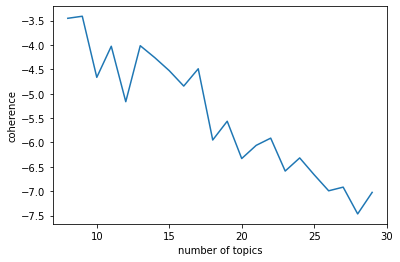

In [6]:
#查询主题个数比较合适
def find_k(docs, min_k, max_k, min_df):
    #min_df 词语最少出现在2个文档中
    import matplotlib.pyplot as plt
    scores = []
    for k in range(min_k, max_k):
        #seed随机种子，保证运行的结果一样
        mdl = tp.LDAModel(min_df=min_df, k=k,seed=555)
        for words in docs:
            if words:
                mdl.add_doc(words)
        mdl.train(20)
        coh = tp.coherence.Coherence(mdl)
        scores.append(coh.get_score())

    #x = list(range(min_k, max_k - 1))  # 区间最右侧的值。注意：不能大于max_k
    #print(x)
    #print()
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()    
    
find_k(docs=data['words'], min_k=8, max_k=30, min_df=2)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# 将文本中的词语转换为词频矩阵
cleanchap = [" ".join(w) for w in data['words']]

Tfidfvectorizer =TfidfVectorizer(max_df=0.4, 
                             min_df=2, 
                             max_features=2000,stop_words=stoplist) #创建词袋数据结构
data_vectorized = Tfidfvectorizer.fit_transform(cleanchap)

In [8]:
pd.DataFrame(data_vectorized.toarray(),columns=Tfidfvectorizer.get_feature_names()).to_csv('data/青桔单车_Tf-idf.csv',encoding='utf_8_sig')

In [9]:
# 设定LDA模型
from sklearn.decomposition import LatentDirichletAllocation
n_topics=8
ldamodel = LatentDirichletAllocation(n_components = n_topics)
ldamodel.fit(data_vectorized)

LatentDirichletAllocation(n_components=8)

In [10]:
# 主题词打印函数
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
n_top_words = 12
tf_feature_names = Tfidfvectorizer.get_feature_names()
print_top_words(ldamodel, tf_feature_names, n_top_words)

Topic #0:
停车 骑行 官方 垃圾 调度 滴滴 地方 真的 骑车 微博 分钟 客服
Topic #1:
滴滴 自行车 自动 电动车 充值 卡天 刘昊然 通用 全国 迟到 骑行 一辆
Topic #2:
哈啰 共享 美团 滴滴 骑行 官方 微博 请问 出行 乱收费 垃圾 客服
Topic #3:
垃圾 吐槽 共享 滴滴 骑车 划算 分钟 城市 车点 破车 朋友 自行车
Topic #4:
共享 手机 刹车 电单车 为啥 每次 真的 代言 骑车 停车 骑单车 刘昊然
Topic #5:
微博 官方 北京 投放 刘昊然 共享 滴滴 视频 陈情 停车 车辆 疫情
Topic #6:
颜色 哈罗 商标 共享 真的 锁上 定位 郑州 半天 新车 特别 电单车
Topic #7:
共享 链接 网页 拼团 骑行 微博 视频 有人 官方 难骑 滴滴 分钟



In [11]:
import joblib
joblib.dump(ldamodel, r'data/青桔model_1.pkl')

['data/青桔model_1.pkl']

In [12]:
import numpy as np

# 构建文档-词频矩阵
lda_output = ldamodel.transform(data_vectorized)
# 列名
topicnames = ["Topic" + str(i) 
              for i in range(ldamodel.n_components)]
# 行索引名
#docnames = ["Doc" + str(i) for i in range(len(data.words))]

# 转化为pd.DataFrame
df_document_topic = pd.DataFrame(np.round(lda_output, 4), 
                                 columns=topicnames, 
                                 index=data['bid'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [13]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
bid,,,,,,,,,
Ho77tk73X,0.0418,0.0418,0.7070,0.0418,0.0420,0.0418,0.0418,0.0418,2
Ho73onWk6,0.0521,0.0521,0.0521,0.0521,0.6355,0.0521,0.0521,0.0521,4
Ho3b5njGV,0.0348,0.0348,0.0348,0.0348,0.7561,0.0348,0.0350,0.0348,4
HnLGE0yE3,0.0470,0.0469,0.0469,0.0469,0.0469,0.0469,0.0469,0.6713,7
LwXlwfLkW,0.0625,0.0625,0.0625,0.5623,0.0625,0.0626,0.0625,0.0626,3


In [14]:
result_data=pd.merge(data,df_document_topic,on='bid')

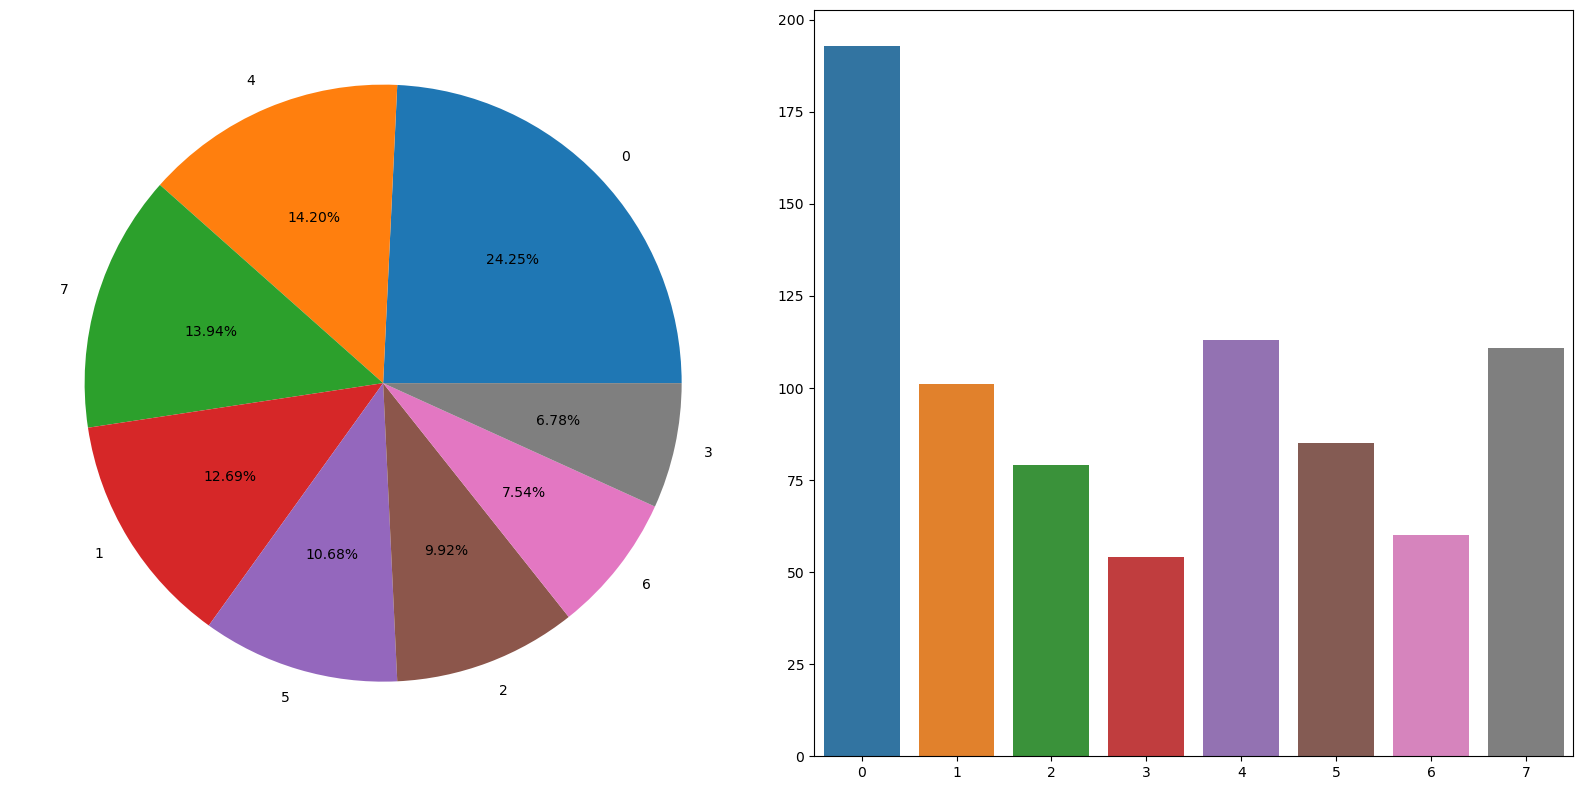

In [15]:
# 主题分布图
import seaborn as sns 
result_type_counts = result_data['dominant_topic'].value_counts()
fig,axes = plt.subplots(1,2,figsize=(16,8),dpi=100)
axes[0].pie(result_type_counts.values,autopct="%.2f%%",labels=result_type_counts.index)
sns.barplot(result_type_counts.index,result_type_counts.values)
plt.savefig(r'data/青桔单车_主题分布图.png')
plt.tight_layout()

In [16]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,193
1,4,113
2,7,111
3,1,101
4,5,85
5,2,79
6,6,60
7,3,54


In [17]:
result_data.to_csv('data/青桔单车_data.csv',encoding='utf_8_sig')